# Анализ развлекательного приложения Procrastinate Pro+

Несколько прошлых месяцев приложение Procrastinate Pro+ постоянно нес убытки, хотя в привлечение пользователей было вложено много денег. Нужно разобраться в причинах этой ситуации.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.



#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

#### План работ



- Загрузка данных и подготовка их к анализу
- Создание функций  для расчета и анализа: LTV, ROI, удержание, конверсия
- Исследовательский анализ данных: профили пользователей,  минимальная и максимальная дата привлечения пользователей. Анализ регионов, устройств, рекламных каналов
- Маркетинг: сумма затраченных средств на рекламу (всего, на каждый рекламный канал, стоимость привлечения одного покупателя из каждого источника)
- Оценка окупаемости рекламы для привлечения пользователей: анализ окупаемости с разбивкой по устройствам, по каналам, по странам c помощью LTV и ROI
- Вывод и рекомендации для рекламного отдела



## Загрузка данных и подготовка их к анализу


Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Загружаем файлы:

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')


Переименуем столбцы для удобства и выведем первые 5 строк каждого датасета:

In [3]:
costs = costs.rename(columns={'Channel': 'channel'})
costs.head(5)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id': 'user_id' , 'session start' : 'session_start', 'session end' : 'session_end'})
visits.head(5)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id': 'user_id', 'event dt' : 'event_dt'})
orders.head(5)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


### Типы данных

Преобразуем данные о времени:

In [6]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.date
visits['session_start'] = pd.to_datetime(visits['session_start']).dt.date
visits['session_end'] = pd.to_datetime(visits['session_end']).dt.date

Проверим типы данных. Убедимся, что типы не нужно изменять:


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Проверка на дубликаты

Сделаем проверку на дубликаты и удалим 2 дубликата из датасета orders:

In [10]:
print (costs.duplicated().sum())
print (orders.duplicated().sum())
print (visits.duplicated().sum())

0
2
0


In [11]:
orders = orders.drop_duplicates()

### Проверка на пропуски

Проверим датасеты на пропуски. Убедимся, что пропусков нет:

In [12]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [13]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [14]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

### Выводы: 

получены и проверены три датасета - orders, visits, costs. Был изменен формат даты во всех датасетах и удалено 2 дубликата из датасета orders. Пропуски в датасетах не обнаружены. 

## Функции для расчета и анализа LTV, ROI, удержания и конверсии; функции для построения графиков



Подготовим функции для дальнейших расчетов.

### Функция для построения profiles: 

In [15]:
def get_profiles(visits, orders, costs, dimensions=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts']
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['total_costs'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'total_costs']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['total_costs'] = profiles['total_costs'].fillna(0)

    return profiles
 
profiles = get_profiles (visits, orders, costs, dimensions=[])

profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,total_costs
0,599326,2019-05-07,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### Функция для расчета удержания (get_retention())

In [16]:


def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

observation_date = datetime(2020, 8, 1).date() 
horizon_days = 7
result_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)
display ( result_in_time)

### Функция для расчета конверсии: get conversion()

In [17]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

###  Функция для расчета LTV и ROI

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'total_costs'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'total_costs': 'mean'})
            .rename(columns={'total_costs': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для визуализации удержания: plot_retention()

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации конверсии: plot_conversion()

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

###  Функция для визуализации LTV и ROI

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


## Исследовательский анализ данных
#### Даты привлечения пользователей

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [23]:
profiles = get_profiles (visits, orders, costs, dimensions=[])
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,total_costs
0,599326,2019-05-07,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


С помощью profiles вычислим минимальную и максимальную дату привлечения клиентов:

In [24]:
profiles['first_ts'].min()

datetime.date(2019, 5, 1)

In [25]:

profiles['first_ts'].max()

datetime.date(2019, 10, 27)

Минимальная дата привлечения пользователей - 1 мая 2019, а максимальная - 27 октября 2019.

#### Распределение пользователей по регионам

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

Видно, что больше всего пользователей приходят из США - 100 тысяч уникальных пользователей из этой страны:

In [26]:
profiles_by_regions =  (
    profiles.groupby('region')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
profiles_by_regions

,region,user_id
0,United States,100002
1,UK,17575
2,France,17450
3,Germany,14981


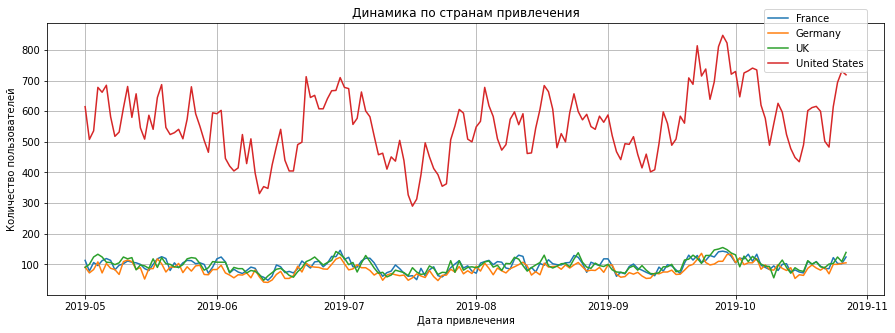

In [27]:
%matplotlib inline
profiles.pivot_table(
    index='first_ts',  # даты первых посещений
    columns='region',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.ylabel('Количество пользователей')
plt.xlabel('Дата привлечения')
plt.title('Динамика по странам привлечения')
plt.legend(bbox_to_anchor = [0.85, 0.8])
plt.show()

Какие страны дают  больше всего платящих пользователей? 
Сгруппируем платящих пользователей по регионам. Видно, что это опять же США: 6902 платящих пользователя.

In [28]:
paying_profiles_regions =  (
     profiles.query('payer == True')
    .groupby('region')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
paying_profiles_regions


,region,user_id
0,United States,6902
1,UK,700
2,France,663
3,Germany,616


### Процент платящих пользователей, распределение по странам 

Проверим, в какой стране выше всего конверсия в покупателей.   
По таблице видно, что это США с конверсией 6.9%:

In [29]:
conversion_per_country = profiles_by_regions.merge(paying_profiles_regions, on='region')
conversion_per_country['conversion_rate'] = (
                conversion_per_country['user_id_y'] / conversion_per_country['user_id_x'] * 100).round(2)
conversion_per_country = conversion_per_country.rename(
                columns={'user_id_x' : 'all_clients', 'user_id_y' : 'paying_clients' })
conversion_per_country


,region,all_clients,paying_clients,conversion_rate
0,United States,100002,6902,6.90
1,UK,17575,700,3.98
2,France,17450,663,3.80
3,Germany,14981,616,4.11


### Устройства, которыми пользуются клиенты, доля платящих для каждого устройства.

Самое популярное устройство у всех пользователей - Айфон:

In [30]:
profiles_devices =  (
    profiles
    .groupby('device')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
profiles_devices

,device,user_id
0,iPhone,54479
1,Android,35032
2,PC,30455
3,Mac,30042


В динамике, Айфон всегда был самым популярным устройством:

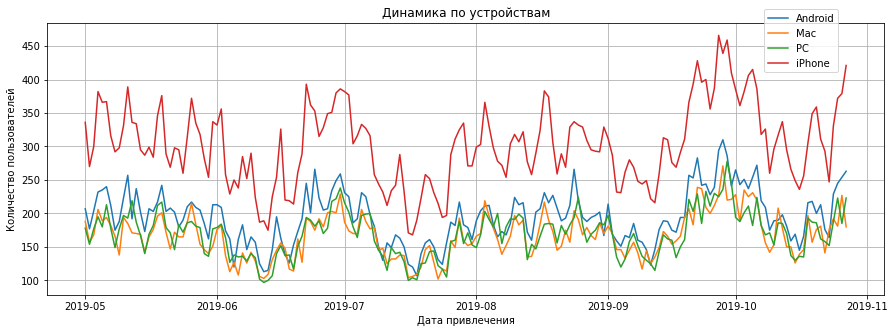

In [31]:
%matplotlib inline
profiles.pivot_table(
    index='first_ts',  # даты первых посещений
    columns='device',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.ylabel('Количество пользователей')
plt.xlabel('Дата привлечения')
plt.title('Динамика по устройствам')
plt.legend(bbox_to_anchor = [0.85, 0.8])
plt.show()

У платящих пользователей любимое устройство тоже Айфон:

In [32]:
paying_profiles_devices =  (
    profiles.query('payer == True')
    .groupby('device')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
paying_profiles_devices

,device,user_id
0,iPhone,3382
1,Android,2050
2,Mac,1912
3,PC,1537


Самая высокая конверсия в покупки у пользователей Mac - 6.36%.

In [33]:
conversion_per_device = profiles_devices.merge(paying_profiles_devices, on='device')
conversion_per_device['conversion_rate'] = (conversion_per_device['user_id_y'] / conversion_per_device['user_id_x'] * 100).round(2)
conversion_per_device = conversion_per_device.rename(columns={'user_id_x' : 'all_clients', 'user_id_y' : 'paying_clients' })

conversion_per_device.sort_values(by='conversion_rate', ascending=False)

,device,all_clients,paying_clients,conversion_rate
3,Mac,30042,1912,6.36
0,iPhone,54479,3382,6.21
1,Android,35032,2050,5.85
2,PC,30455,1537,5.05


### Рекламные источники привлечения 

По каким рекламным каналам шло привлечение пользователей?  Какие каналы приносят больше всего платящих пользователей?

Больше всего пользователей попадают в приложение самостоятельно, без помощи рекламы (канал 'Organic'). Второе и третье место в списке заняли FaceBoom и TipTop:

In [34]:
profiles_by_channels =  (
    profiles.groupby('channel')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
profiles_by_channels 

,channel,user_id
0,organic,56439
1,FaceBoom,29144
2,TipTop,19561
3,OppleCreativeMedia,8605
4,LeapBob,8553
5,WahooNetBanner,8553
6,RocketSuperAds,4448
7,MediaTornado,4364
8,YRabbit,4312
9,AdNonSense,3880


Наибольшее число платящих пользователей приходит из каналов FaceBoom и TipTop:

In [35]:
paying_profiles_by_channels =  (
    profiles.query('payer == True').groupby('channel')
    .agg({'user_id' : 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
paying_profiles_by_channels

,channel,user_id
0,FaceBoom,3557
1,TipTop,1878
2,organic,1160
3,WahooNetBanner,453
4,AdNonSense,440
5,RocketSuperAds,352
6,LeapBob,262
7,OppleCreativeMedia,233
8,lambdaMediaAds,225
9,YRabbit,165


В динамике, с мая больше всего выросло количество пользователей с FaceBoom:

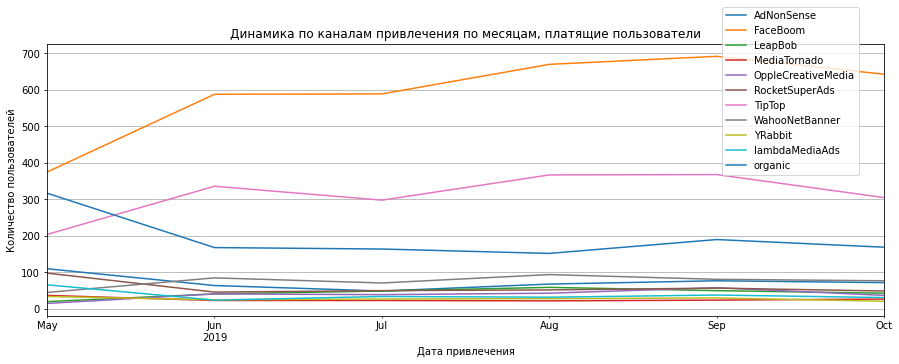

In [36]:
%matplotlib inline
profiles.query('payer == True').pivot_table(
    index='month',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.ylabel('Количество пользователей')
plt.xlabel('Дата привлечения')
plt.title('Динамика по каналам привлечения по месяцам, платящие пользователи')
plt.legend(bbox_to_anchor = [0.8, 0.5])
plt.show()

Самая высокая конверсия у каналов FaceBoom, AdNonSense, lambdaMediaAds:

In [37]:
conversion_per_channel = profiles_by_channels.merge(paying_profiles_by_channels, on='channel')
conversion_per_channel['conversion_rate'] = (
                             conversion_per_channel['user_id_y'] / conversion_per_channel['user_id_x'] * 100).round(2)

conversion_per_channel = conversion_per_channel.rename(
                                                columns={'user_id_x' : 'all_clients', 'user_id_y' : 'paying_clients' })

conversion_per_channel.sort_values(by='conversion_rate', ascending=False)

,channel,all_clients,paying_clients,conversion_rate
1,FaceBoom,29144,3557,12.20
9,AdNonSense,3880,440,11.34
10,lambdaMediaAds,2149,225,10.47
2,TipTop,19561,1878,9.60
6,RocketSuperAds,4448,352,7.91
5,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
7,MediaTornado,4364,156,3.57
4,LeapBob,8553,262,3.06
3,OppleCreativeMedia,8605,233,2.71


## Вывод

Мы выяснили, что:
- большая часть пользователей, в том числе платящих, приходит из США. В США  конверсия самая высокая - 6.9%.
- cамое популярное устройство у всех пользователей, в том числе платящих  - Айфон, но конверсия выше у пользователей 
Mac (6.36%)
- большинство пользователей попадает в приложение самостоятельно, не используя рекламные баннеры
- среди платящих пользователей большая часть привлечена через каналы FaceBoom и TipTop
- самая высокая конверсия пользователей в покупателей - у каналов FaceBoom, AdNonSense, lambdaMediaAds, TipTop (конверсия составляет 9-12%). 
- самая низкая конверсия в покупателей у канала Organic, через который в приложение попадает большая часть пользователей.		


# Маркетинг


Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

### Общая сумма расходов на маркетинг

Подсчитаем общие расходы на маркетинг за весь период. Они составили 105497 руб.:

In [38]:
sum_costs = costs['costs'].sum()
sum_costs

105497.30000000002

###  Cумма расходов на маркетинг по каналам привлечения

Просуммируем расходы по каналам. Видно, что больше всего денег уходит на TipTop (половина рекламного бюджета). Следом идет FaceBoom:

In [39]:
sum_costs_per_channel = costs.groupby('channel').agg({'costs' : 'sum'}).reset_index().sort_values(
                                                                                      by='costs', ascending=False)
sum_costs_per_channel['percentage'] = round(sum_costs_per_channel['costs'] / sum_costs * 100, 1)
sum_costs_per_channel

,channel,costs,percentage
6,TipTop,54751.30,51.9
1,FaceBoom,32445.60,30.8
7,WahooNetBanner,5151.00,4.9
0,AdNonSense,3911.25,3.7
4,OppleCreativeMedia,2151.25,2.0
5,RocketSuperAds,1833.00,1.7
2,LeapBob,1797.60,1.7
9,lambdaMediaAds,1557.60,1.5
3,MediaTornado,954.48,0.9
8,YRabbit,944.22,0.9


Визуализируем каналы расходов и динамику расходов во времени. Расходы на рекламу в TipTop и FaceBoom явно возрастают:

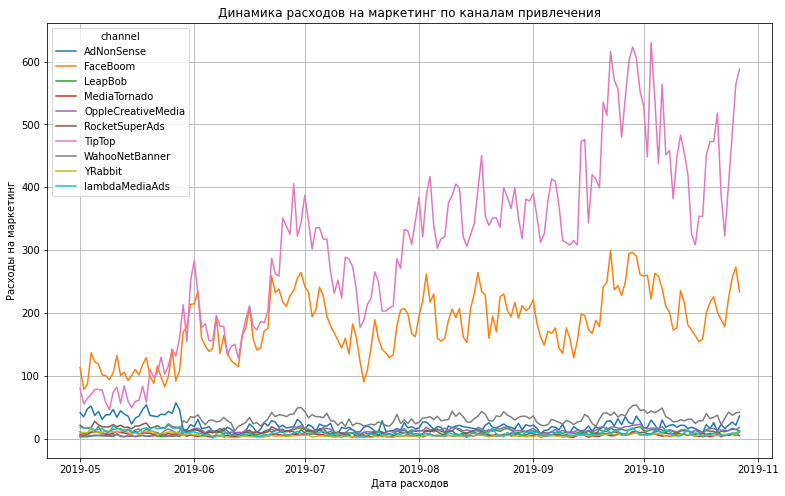

In [40]:
costs_per_channel  =  pd.pivot_table(costs, values='costs', 
                                     columns='channel', index='dt').plot(figsize=(13,8), kind='line',
                                     title='Динамика расходов на маркетинг по каналам привлечения', 
                                     ylabel='Расходы на маркетинг', xlabel='Дата расходов', grid=True)

### Средний CAC на одного пользователя и на одного пользователя из каждого источника трафика

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

В профилях уже расчитана стоимость привлечения каждого пользователя по каналу и по дате привлечения. Проверим, это для пользователей FaceBoom:

In [41]:
profiles_fb = profiles.query('channel == "FaceBoom"').sort_values(by='dt')
profiles_fb.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,total_costs
28757,191304915702,2019-05-01,FaceBoom,Mac,United States,2019-05-01,2019-05-01,False,1.089423
114523,763233345611,2019-05-01,FaceBoom,Android,United States,2019-05-01,2019-05-01,False,1.089423
114479,762955091588,2019-05-01,FaceBoom,Android,United States,2019-05-01,2019-05-01,False,1.089423
139137,927823413821,2019-05-01,FaceBoom,Mac,United States,2019-05-01,2019-05-01,False,1.089423
2238,15174034813,2019-05-01,FaceBoom,iPhone,United States,2019-05-01,2019-05-01,False,1.089423


Нам нужно рассчитать стоимость привлечения для всех пользователей и для пользователя в среднем по каналам.
- Чтобы рассчитать стоимость привлечения всех пользователей, нужно общую сумму разделить на сумму уникальных пользователей.
- Чтобы рассчитать сумму по каналам, нужно сумму, затраченную на канал разделить на сумму пользователей канала.

In [42]:
profiles['total_costs'].sum()

105497.29999999999

In [43]:
profiles['user_id'].count()

150008

Теперь разделим сумму трат на количество уникальных пользователей:

In [44]:
sum_per_user = profiles['user_id'].count() / profiles['total_costs'].sum()
sum_per_user 

1.4219131674459917

Так мы узнали, что в среднем каждый привлеченный пользователь обходится компании в 1.4 рубля.  
Теперь рассчитаем, во сколько обходится привлечение пользователя каждого канала:

In [45]:
profiles_grouped = profiles.groupby('channel').agg({'total_costs' : 'sum', 'user_id' : 'count'})
profiles_grouped['client_cost'] = profiles_grouped['total_costs'] / profiles_grouped['user_id']
profiles_grouped.sort_values(by='client_cost', ascending=False)

,total_costs,user_id,client_cost
channel,,,
TipTop,54751.30,19561,2.799003
FaceBoom,32445.60,29144,1.113286
AdNonSense,3911.25,3880,1.008054
lambdaMediaAds,1557.60,2149,0.724802
WahooNetBanner,5151.00,8553,0.602245
RocketSuperAds,1833.00,4448,0.412095
OppleCreativeMedia,2151.25,8605,0.250000
YRabbit,944.22,4312,0.218975
MediaTornado,954.48,4364,0.218717


Дороже всего компании обходятся пользователи Tip Top. Однако ранее мы заметили, что эта группа пользователей только на четвертом месте по уровню конверсии. Канал AdNonSense имеет лучшую конверсию, а стоимость привлечения пользователей более чем в два раза ниже, чем в TipTop.

## Выводы

Мы узнали, что общие расходы на маркетинг за весь период составили 105497 руб. Около половины этой суммы - 54751 руб. - было потрачено для привлечение по каналу TipTop. В динамике, расходы на TipTop и FaceBoom c мая возрастали. Расходы на другие каналы, кроме FaceBoom и TipTop, незначительны.

Средний пользователь обходится компании в 1.4 руб. Самые дорогие пользователи - из канала TipTop, где один пользователь обходится в 2.8 руб. В то же время, группа пользователей TipTop только на четвертом месте по уровню конверсии. Канал AdNonSense имеет лучшую конверсию, а стоимость привлечения пользователей (1 руб.) - более чем в два раза ниже, чем в TipTop.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Поэтому зададим горизонт наблюдения - 2 недели, в течение которых реклама должна окупиться.


### Общая окупаемость рекламы. 

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Зададим горизонт анализа - 14 дней,  и дату наблюдения. Исключим из анализа канал Organic, так как рекламный бюджет на него не расходуется.

In [46]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

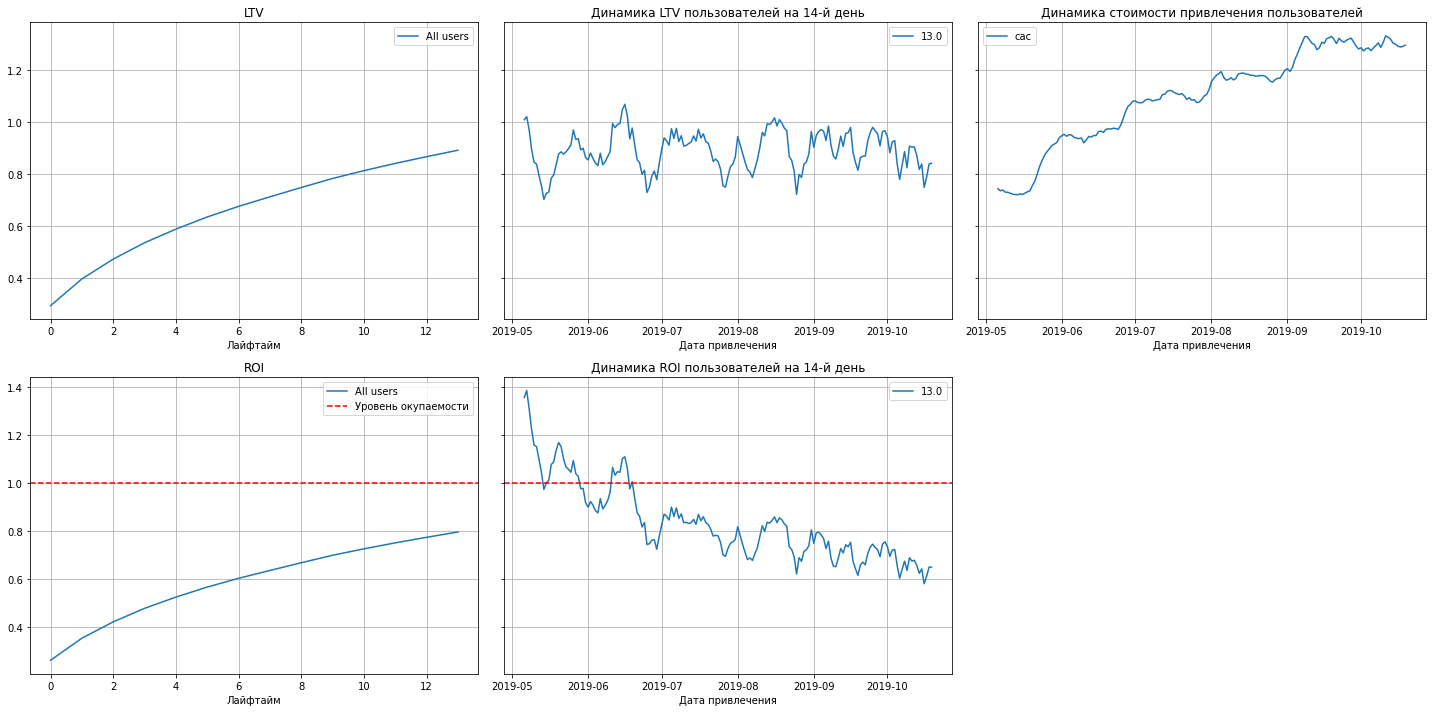

In [47]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=6)

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI на 14й день не пересекает прямую уровня окупаемости.
- В динамике ROI падает 
- CAC нестабилен и увеличивается. На предыдущих графиках мы уже видели, что расходы на маркетинг растут.
Явно увеличиваются расходы на одного пользователя.
- Динамика LTV стабильна

Можно предположить, что рекламный бюджет расходуется неоптимально. Вероятно, много средств затрачивается на рекламу в каналах с низкой конвертацией.



### Окупаемость рекламы с разбивкой по рекламным каналам. 

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по рекламным каналам:

In [48]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

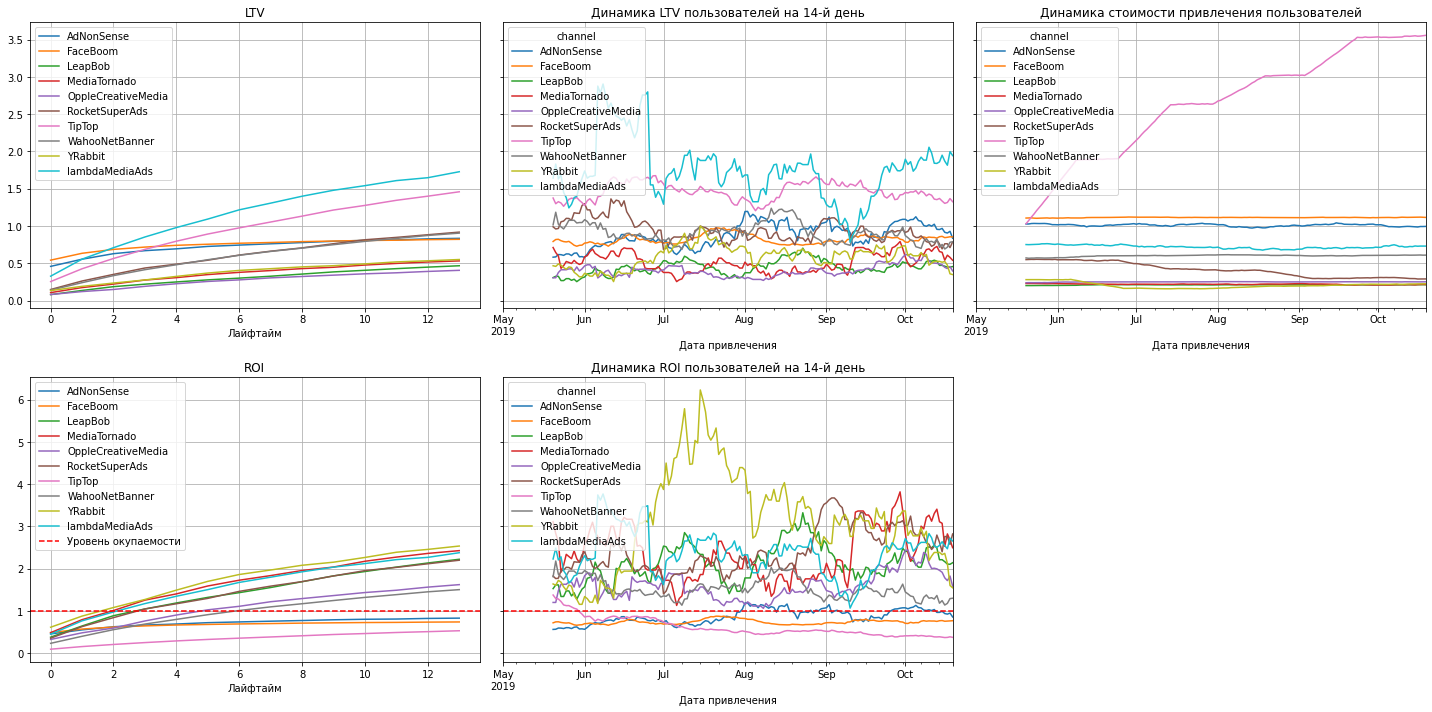

In [49]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
)

По графикам можно сделать такие выводы:
- ROI ниже окупаемости по каналам TipTop, AdNonSense и FaceBoom
- ROI выше окупаемости по каналам YRabbit, MediaTornado, lambdaMediaArts
- По уровню LTV лидер  lambdaMediaAds, затем идет Tip Top 
- CAC по каналу Tip Top нестабилен и увеличивается
- Динамика LTV и ROI относительно стабильна, с колебаниями

Можно предположить, что главным образом затраты на TipTop негативно влияют на динамику всего CAC.


### Окупаемость рекламы с разбивкой по странам. 

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

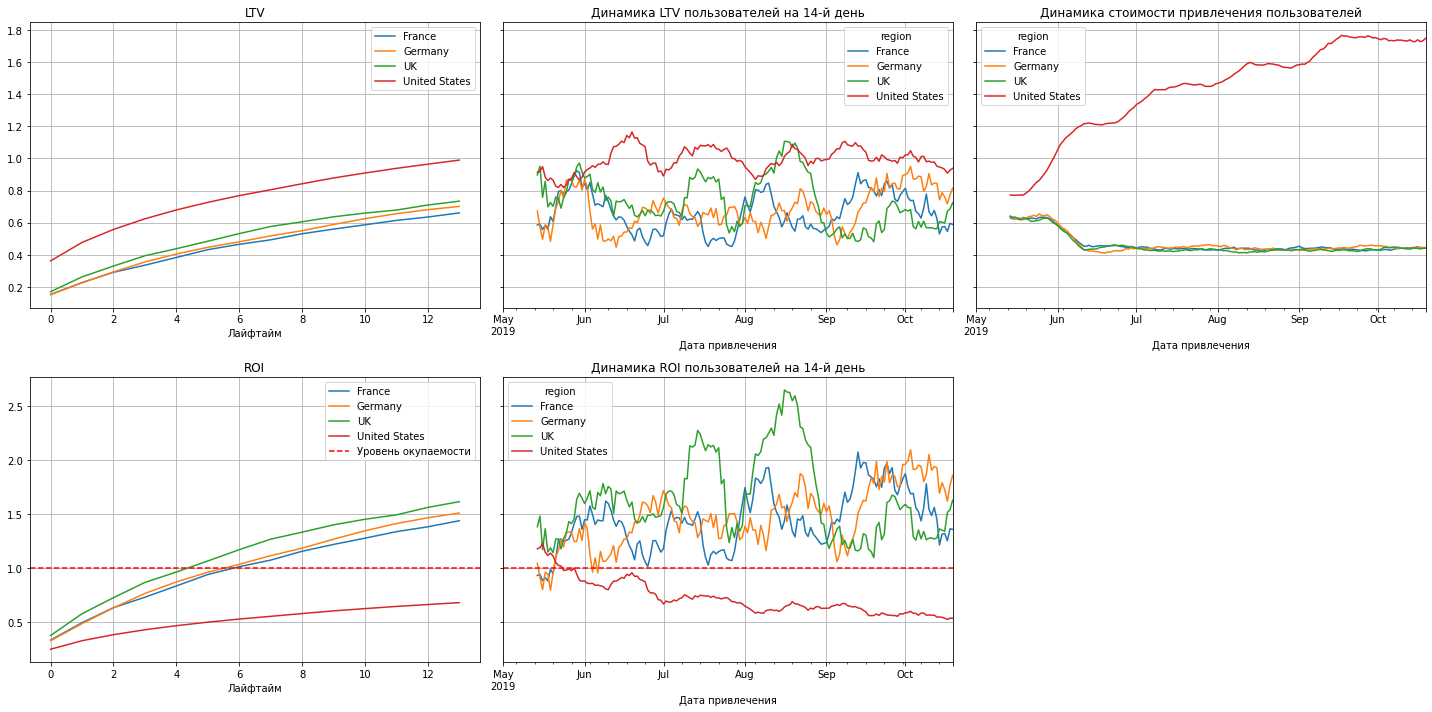

In [50]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:
- ROI ниже окупаемости в США. Остальные страны окупаются.
- По уровню LTV лидер США
- CAC по региону США  нестабилен и увеличивается. По остальным регионам CAC стабилен.
- Динамика LTV по всем регионам относительно стабильна, с колебаниями
- Динамика ROI относительно стабильна, за исключением США; регион с июня перестал окупаться.

Можно предположить, что главным образом затраты в регионе США негативно влияют на динамику всего CAC и снижают ROI.

Изучим рекламу в США отдельно и увидим, что CAC растет, а ROI падает:

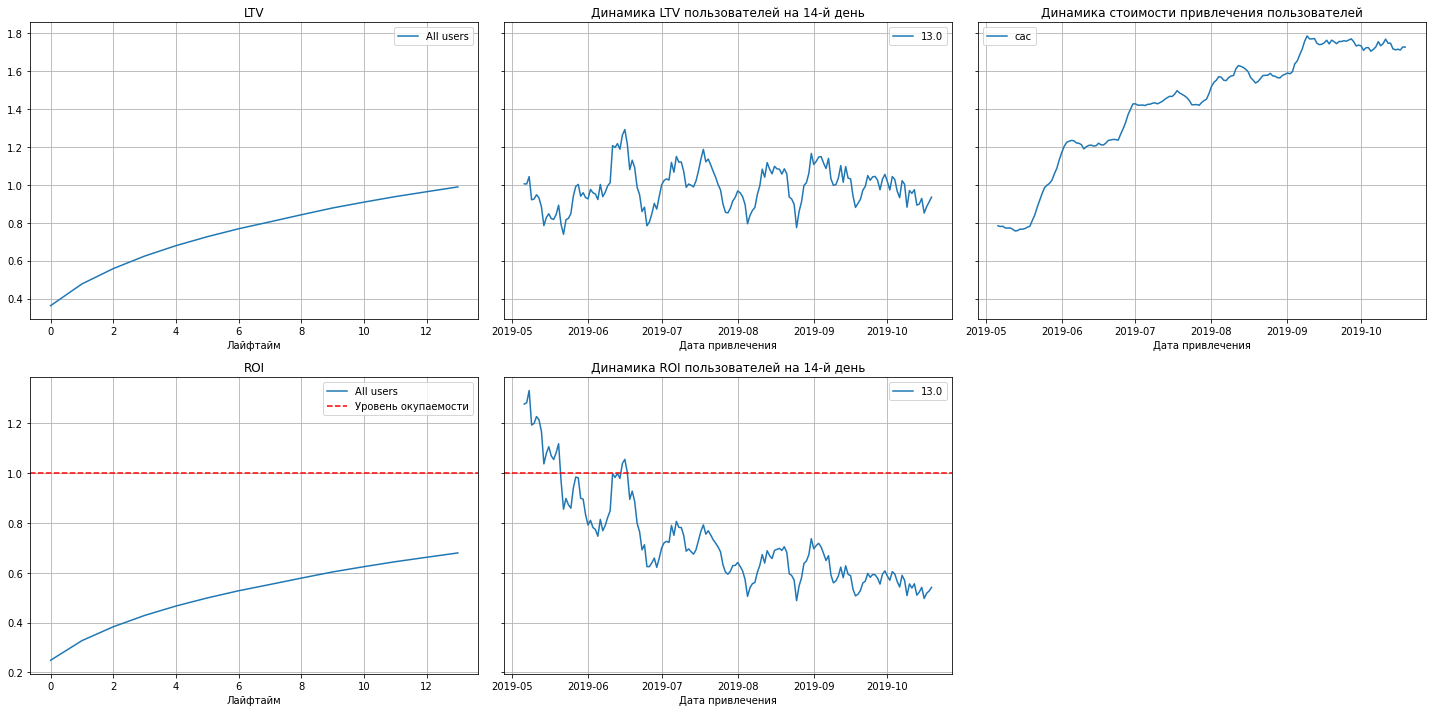

In [51]:
profiles_usa = profiles.query('region == "United States" & channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=6)

Теперь посмотрим на все регионы, кроме США и увидим, что показатели хорошие: стабильный CAC, хорошая окупаемость. Значит, США 'тянут' показатели вниз:

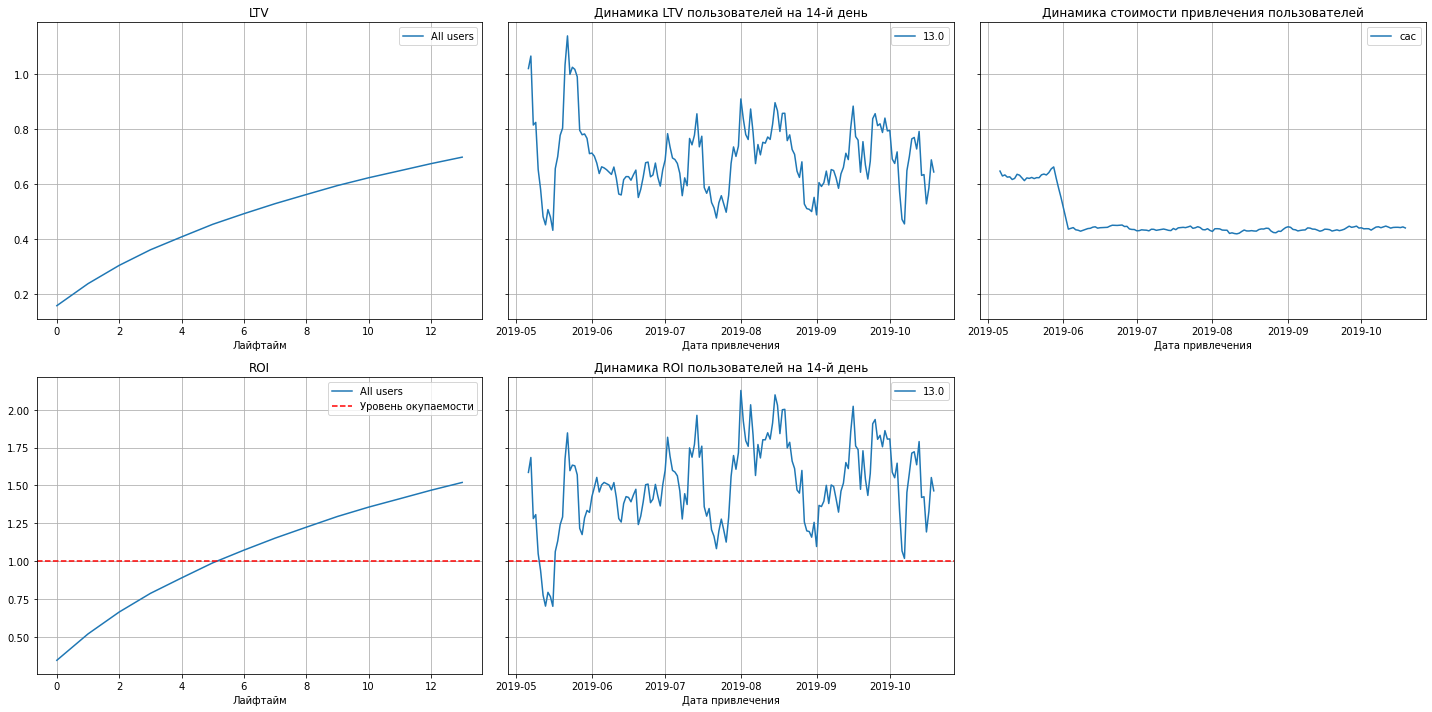

In [52]:
profiles_not_usa = profiles.query('region != "United States" & channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_usa, orders, observation_date, horizon_days
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=6)

## Окупаемость рекламы с разбивкой по устройствам.

На устройствах Mac, IPhone, Andriod реклама не окупается, стоимость привлечения пользователей на этих устройствах увеличивается:

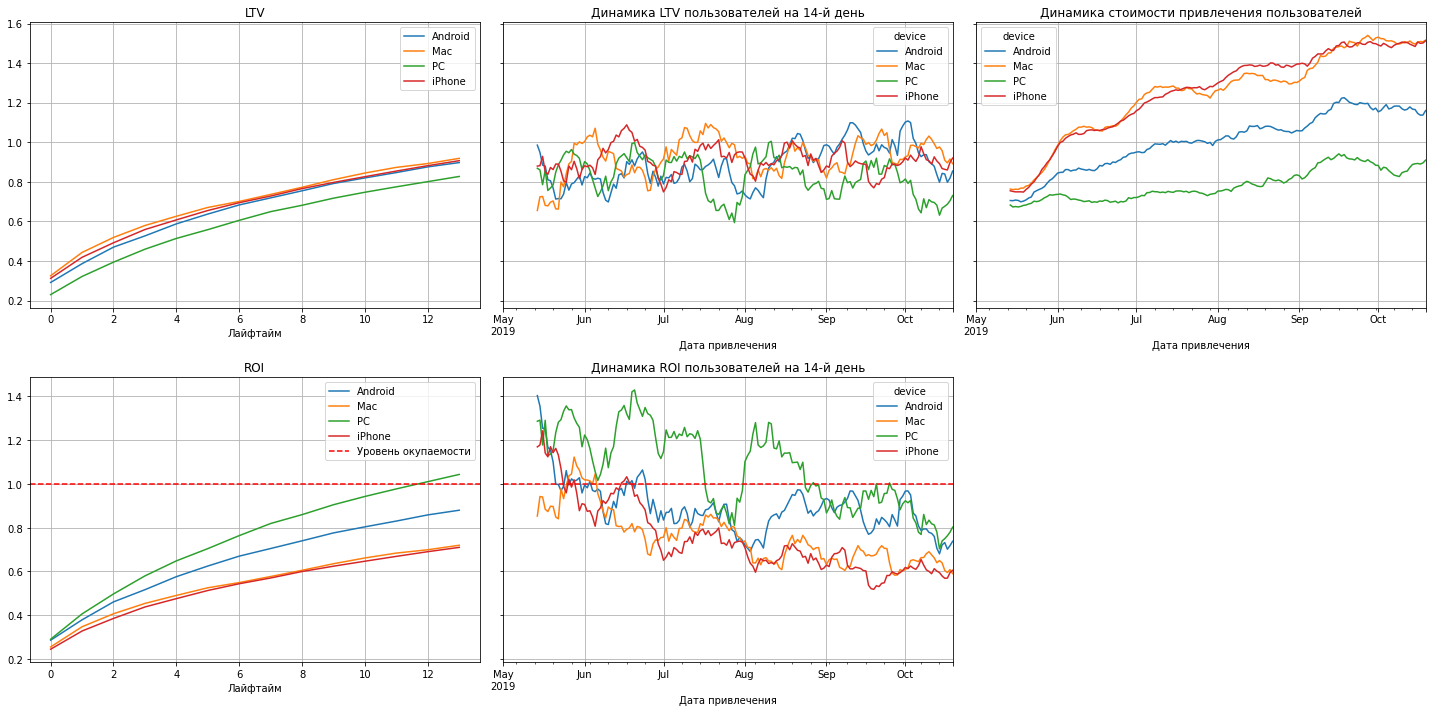

In [53]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

## Выводы

 - Реклама не выходит на окупаемость на 14й день
 - Общая динамика ROI отрицательная 
 - Стоимость привлечения покупателей в динамике увеличивается
 - Каналы: ROI ниже окупаемости по каналам TipTop, AdNonSense и FaceBoom
 - Регионы: регион США с июня перестал окупаться. Остальные регионы окупаются.
 - Устройства: реклама на IPhone, Мас и Аndroid не окупается



### Графики конверсии  с разбивкой по устройствам, странам, рекламным каналам.

Построим графики конверсии с разбивкой по устройствам, странам, рекламным каналам.

По устройствам: самая низкая конверсия у пользователей PC:

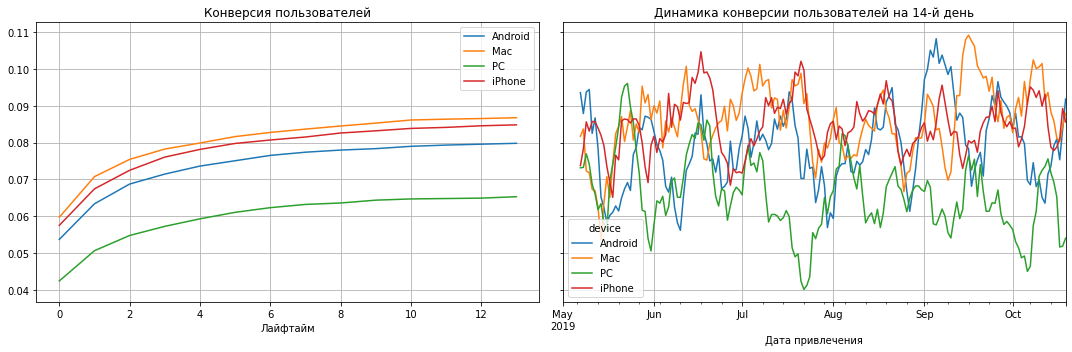

In [54]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По регионам:
cамая высокая конверсия - у пользователей из США:

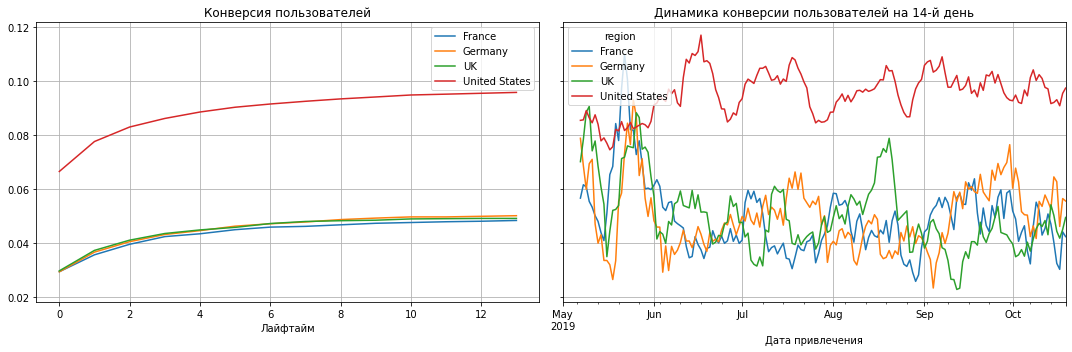

In [55]:
# смотрим конверсию с разбивкой по регионам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По каналам: cамая высокая конверсия - в каналах FaceBoom, AdNonSense, lambdaMediaAds:

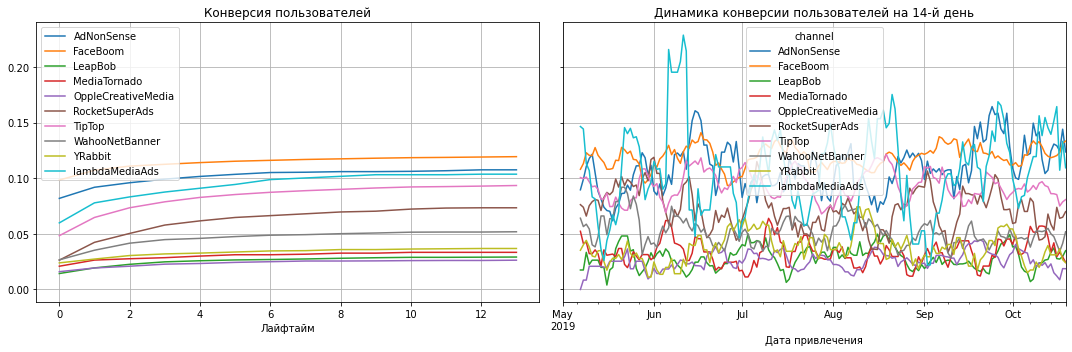

In [56]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### Графики  удержания с разбивкой по устройствам, странам, рекламным каналам.

Построим графики удержания с разбивкой по устройствам, странам, рекламным каналам.

По устройствам динамика удержания примерно одинакова:

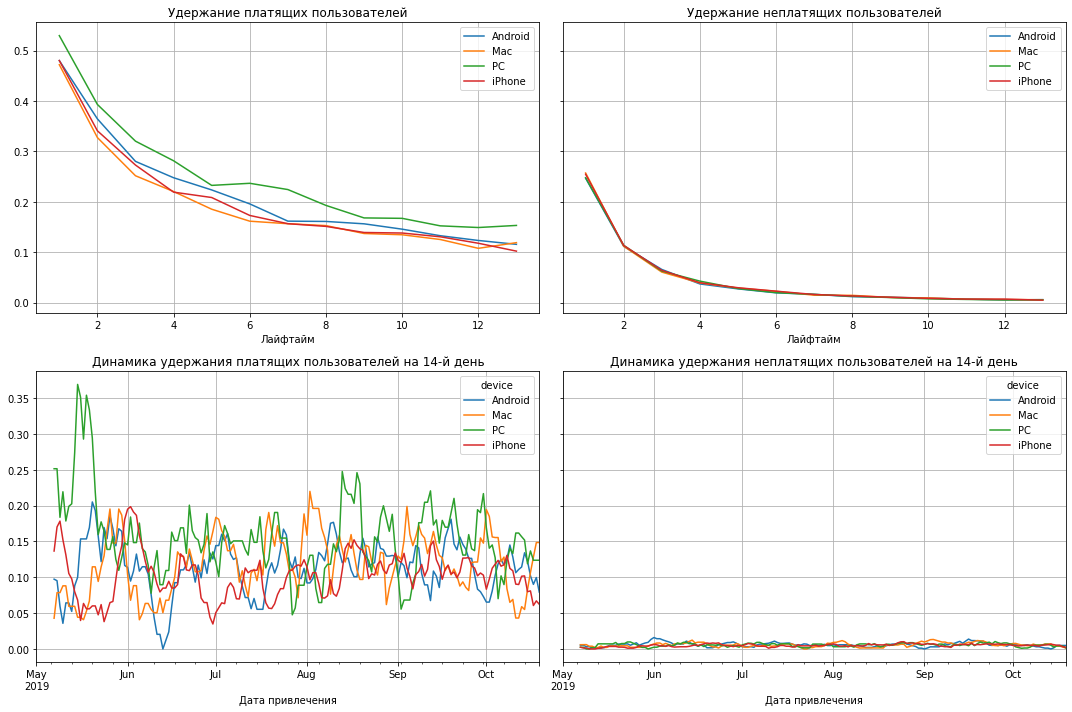

In [57]:
# смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По регионам, пользователи США удерживаются хуже всех:

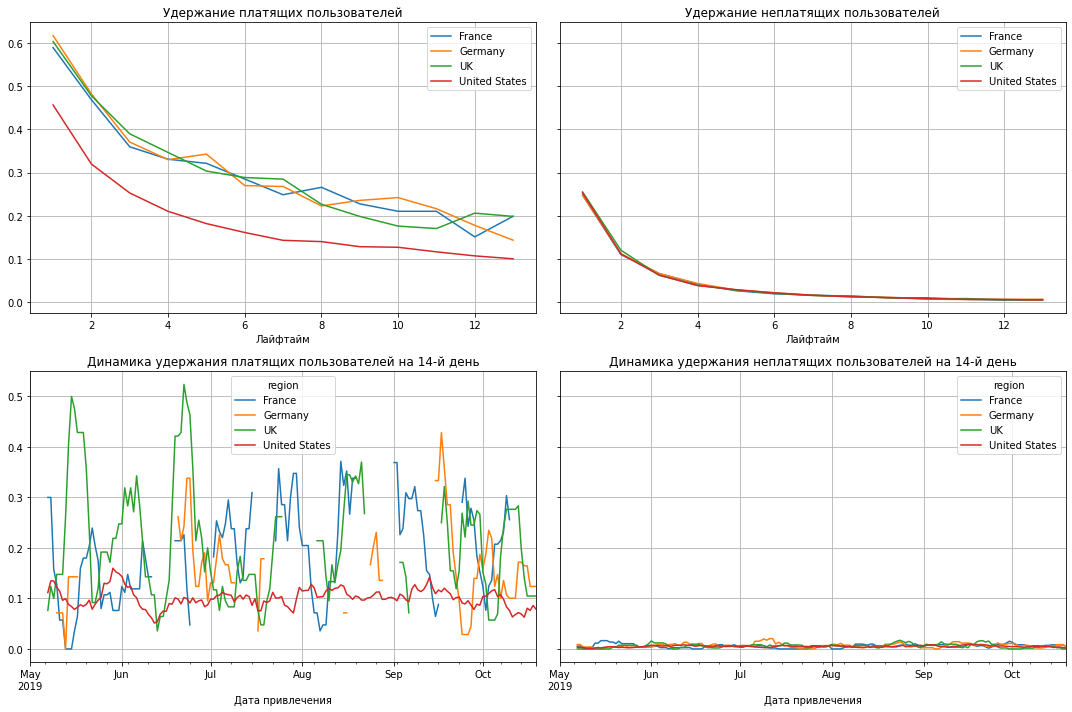

In [58]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По каналам, хуже всех удерживаются пользователи FaceBoom и AdNonSense:

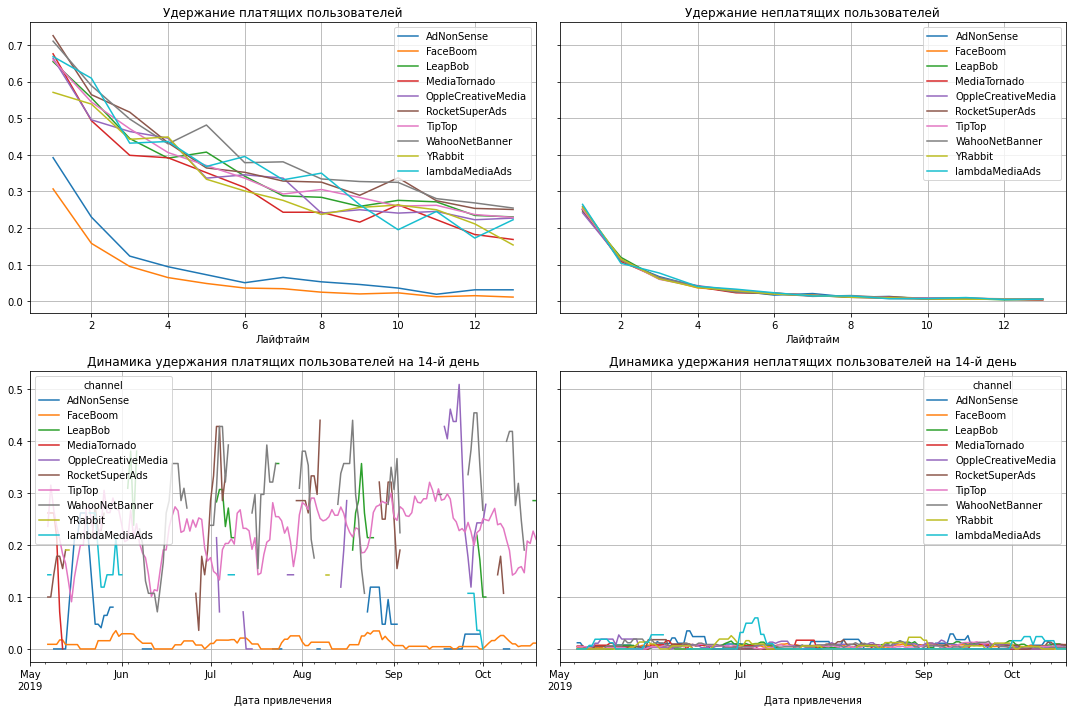

In [59]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Вывод

 - Реклама не выходит на окупаемость на 14й день
 - Общая динамика ROI отрицательная 
 - Стоимость привлечения покупателей в динамике увеличивается
 - Каналы: ROI ниже окупаемости по каналам TipTop, AdNonSense и FaceBoom
 - Регионы: регион США с июля перестал окупаться. Остальные регионы окупаются.
 - Устройства: реклама на IPhone, Android и Мас не окупается
 - Конверсия: самая высокая в США, ниже по другим регионам
 - Удержание: среди всех регионов, самое низкое в США; среди каналов - в каналах FaceBoom и AdNoNSense

По графикам видно, что следующие устройства, страны и рекламные каналы оказывают негативное влияние окупаемость рекламы:
-  повышенные расходы на канале TipTop
-  повышенные расходы в США
-  неокупающаяся реклама на устройствах Mac, IPhone, Android


Проблемы окупаемости могут быть вызваны следующими факторами: 
- неравномерное распределение рекламного бюджета
- низкая конверсия пользователей PC
- низкая конверсия европейских регионов
- низкое удержание в регионе США
- низкое удержание в каналах FaceBoom и AdNoNSense



### Рекомендации для рекламного отдела

	
- изучить тарифы на канале TipTop и возможно, подобрать более дешевый тариф
- увеличить конверсию европейских пользователей
- увеличить конверсию пользователей PC
- увеличить удержание пользователей в США
- увеличить удержание пользователей FaceBoom и AdNoNSense



#  Выводы

Было проанализировано три датасета: лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Были выполнены следующие работы:

- Загрузка данных и подготовка их к анализу
- Создание функций  для расчета и анализа: LTV, ROI, удержание, конверсия
- Исследовательский анализ данных: профили пользователей,  минимальная и максимальная дата привлечения пользователей. Анализ регионов, устройств, рекламных каналов
- Маркетинг: сумма затраченных средств на рекламу (всего, на каждый рекламный канал, стоимость привлечения одного покупателя из каждого источника)
- Оценка окупаемости рекламы для привлечения пользователей: анализ окупаемости с разбивкой по устройствам, по каналам, по странам c помощью LTV и ROI
- Вывод и рекомендации для рекламного отдела

Проведя анализ, мы выяснили, что:

- большая часть пользователей, в том числе платящих, приходит из США. В США конверсия самая высокая - 6.9%.
- cамое популярное устройство у всех пользователей, в том числе платящих - Айфон, но конверсия выше у пользователей Mac (6.36%)
- большинство пользователей попадает в приложение самостоятельно, не используя рекламные баннеры
- среди платящих пользователей большая часть привлечена через каналы FaceBoom и TipTop
- самая высокая конверсия пользователей в покупателей - у каналов FaceBoom, AdNonSense, lambdaMediaAds, TipTop (конверсия составляет 9-12%).
- самая низкая конверсия в покупателей у канала Organic, через который в приложение попадает большая часть пользователей.

Общие расходы на маркетинг за весь период составили 105497 руб. Около половины этой суммы - 54751 руб. - было потрачено для привлечения по каналу TipTop. В динамике, расходы на TipTop c мая возрастали. Маркетинговые расходы на другие каналы, кроме FaceBoom и TipTop, незначительны.

Средний пользователь обходится компании в 1.4 руб. Самые 'дорогие' пользователи - из канала TipTop, где один пользователь обходится в 2.8 руб. В то же время, группа пользователей TipTop только на четвертом месте по уровню конверсии. Канал AdNonSense имеет лучшую конверсию, а стоимость привлечения пользователей (1 руб.) - более чем в два раза ниже, чем в TipTop.

### Причины неэффективности привлечения пользователей:

 Следующие устройства, страны и рекламные каналы оказывают негативное влияние окупаемость рекламы:
-  повышенные расходы на канале TipTop
-  повышенные расходы в США
-  неокупающаяся реклама на устройствах Mac, IPhone, Android

### Рекомендации для отдела маркетинга.

- пересмотреть рекламный бюджет и перераспределить средства c канала Tip Top на более дешевые каналы с высокой конверсией, как lambdaMediaAds, YRabbit, MediaTornado
- улучшить удержание пользователей в США
- улучшить удержание пользователей FaceBoom и AdNoNSense
- улучшить конверсию европейских пользователей
- улучшить конверсию пользователей PC
- реклама на IPhone, Мас, Android не окупается, проверить техническое состояние приложений на этих устройствах
